**Two-link Planar Arm:**

Length of each link ($l$) = 0.5

action: $[w0, w1]$ <br />
$w0$ = joint1 angular velocity <br />
$w1$ = joint2 angular velocity

state: $[t0, t1]$ <br />
$t0$ = joint1 angle <br />
$t1$ = joint2 angle <br />

position of end effector: <br />
$x$ = x position <br />
$y$ = y position <br />

In [28]:
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

logger = logging.getLogger(__name__)

In [29]:
# environment parameters

dt = 0.1 # time interval
length = 1. # length of each link
omega = 0.1 # max angular velocity of motor

In [30]:
# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def ang_pos(state):
        x = t.matmul(length*t.cos(state),t.tensor([1.,1.]))
        y = t.matmul(length*t.sin(state),t.tensor([1.,1.]))
        pos = t.transpose(t.stack((x,y),dim=0),0,1)
        return pos

    @staticmethod
    def forward(state, action):
        state = state + dt*omega*action # angle(t+dt) = angle(t) + dt * angular_velocity(t)
        return state

In [31]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Tanh()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [32]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, n):
        super(Simulation, self).__init__()
        self.T = T
        self.state = self.initialize_state(n)
        self.target = self.generate_target(n)
        self.controller = controller
        self.dynamics = dynamics
        self.action_trajectory = []
        self.pos_trajectory = []
        self.state_trajectory = []

    def forward(self, state, target ,n):
        self.action_trajectory = []
        self.state_trajectory = []
        self.pos_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            pos = self.dynamics.ang_pos(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
            self.pos_trajectory.append(pos)
        return self.error( pos, target, n)

    @staticmethod
    def initialize_state(n):
        initial = 2*math.pi*(t.rand(n,2)-0.5)  # vertical state
        print('Generate %d pairs of initial angle of joints' % n)
        print(initial)
        return initial
    @staticmethod
    def generate_target(n):
        target = np.zeros((n,2))
        for i in range(n):
            ang = 2*math.pi*random.random()
            radius = random.random()
            target[i] = [radius*math.cos(ang), radius*math.sin(ang)] # generator points in work space
        print('Generate %d target:' % n)
        print(target)
        return t.tensor(target, requires_grad=False).float()

    def error(self, pos, target, n):
        dist = target-pos
        loss = t.square(dist).sum(dim=0).sum(dim=0)/n
        return loss

In [33]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.1) #, line_search_fn='strong_wolfe')

    def step(self,n):
        def closure():
            loss = self.simulation(self.simulation.state, self.simulation.target, n)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, eps, max_epoch, n):
        conv_log = []
        conv_itr = []
        epoch = 0
        error = 100
        print('Start Training:')
        while error > eps and epoch <= max_epoch:
            loss = self.step(n)
            conv_log.append(loss.item())
            conv_itr.append(epoch)
            epoch += 1
            print('[%d] loss: %.6f' % (epoch, loss))
            error = loss.item()
            cord = self.visualize()
        print('Landing Trajectory:')
        for r in range(n):
            plt.scatter(cord[:-1,r,0], cord[:-1,r,1],s=5)
            plt.scatter(cord[-2,r,0], cord[-2,r,1],s=300,marker='x')
            plt.scatter(cord[-1,r,0],cord[-1,r,1],s=500,marker='+')
            plt.show()
        print('Convergence Plot:')
        plt.plot(conv_itr, conv_log)
        plt.yscale("log")
        plt.show()

    def visualize(self):
        data = np.array([self.simulation.pos_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        goal = np.expand_dims(np.array(self.simulation.target.detach().numpy()), axis=0)
        data = np.append(data,goal,axis=0) # goal = data2[-1,:,:], data = goal = data2[:-1,:,:]
        plt.scatter(data[:-1,0,0], data[:-1,0,1],s=5)
        plt.scatter(data[-2,0,0], data[-2,0,1],s=300,marker='x')
        plt.scatter(data[-1,0,0],data[-1,0,1],s=500,marker='+')
        plt.show()
        return data

In [34]:
# class Evaluation:
#     def __init__(self, simulation):
#         self.simulation = simulation
#
#     def test(self, n):
#         print('Start Testing:')
#         loss = self.simulation(self.simulation.state,n)
#         print('loss: %.6f' % loss)
#         data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
#         print('Landing Trajectory:')
#         for r in range(n):
#             plt.plot(w1, h, color="red", linewidth=3)
#             plt.plot(w2, h, color="green", linewidth=3)
#             plt.quiver(data[:,r, 2], data[:,r, 4], -0.05*np.sin(data[:,r, 0]), 0.05*np.cos(data[:,r, 0]))
#             plt.quiver(data[-1,r, 2], data[-1,r, 4], -0.05*np.sin(data[-1,r, 0]), 0.05*np.cos(data[-1,r, 0]),color='orange')
#             plt.show()
#             end = data[-1,r,:]
#             print(np.abs(end))

Generate 100 pairs of initial angle of joints
tensor([[-0.5569,  1.2877],
        [ 0.3636,  2.7400],
        [ 2.0453,  0.2076],
        [-2.5944, -2.8921],
        [ 2.5225,  1.5788],
        [ 0.1481, -1.3136],
        [-2.3189, -2.2494],
        [-1.4400,  0.3841],
        [ 1.6194,  1.2373],
        [-0.0733, -1.1517],
        [-2.4413,  1.2107],
        [ 2.5647, -1.6892],
        [-0.6835, -1.9183],
        [ 1.1534,  0.9589],
        [-1.5565, -2.9024],
        [ 1.1768, -1.1387],
        [ 2.1743, -2.8736],
        [-2.8193,  0.1705],
        [-2.4190, -1.6518],
        [ 1.6613, -2.9226],
        [-0.8324,  0.4092],
        [-1.0461,  3.1401],
        [ 1.2976, -2.7321],
        [-0.0084, -2.1827],
        [-0.9148,  2.0496],
        [-0.1928, -1.9918],
        [-1.1087,  2.4781],
        [-2.9592,  2.5603],
        [-0.5650,  1.1302],
        [-2.2719, -0.4047],
        [ 1.1154, -2.5735],
        [-3.0895, -0.8676],
        [-2.5802,  1.7953],
        [ 2.1808,  1.4607],
  

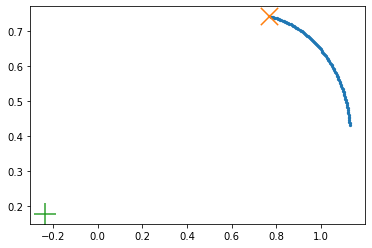

[2] loss: 1.192602


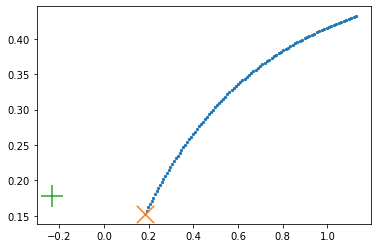

[3] loss: 0.831638


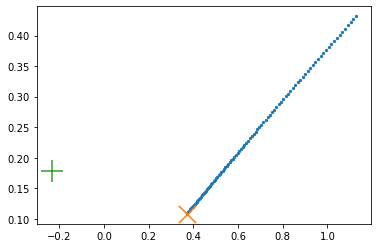

[4] loss: 0.750503


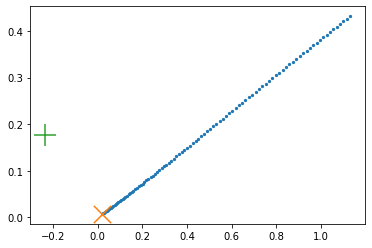

[5] loss: 0.727139


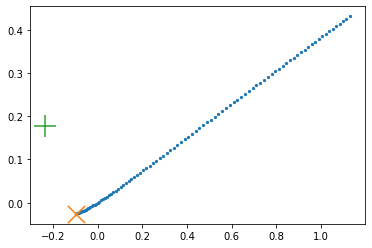

[6] loss: 0.721645


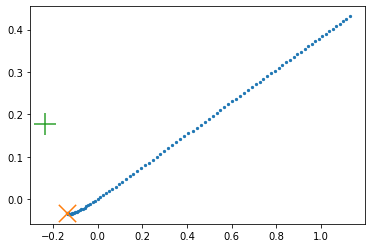

[7] loss: 0.719852


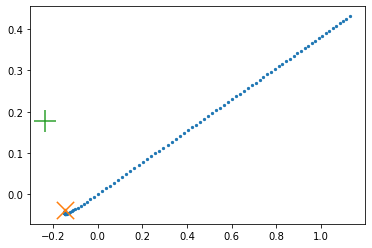

[8] loss: 0.719136


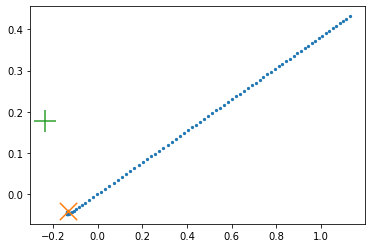

[9] loss: 0.718144


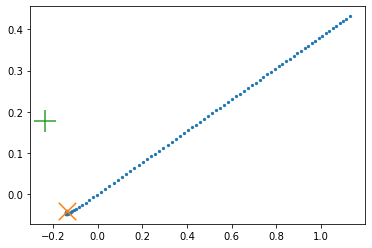

[10] loss: 0.717648


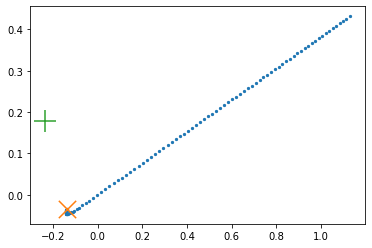

[11] loss: 0.717148


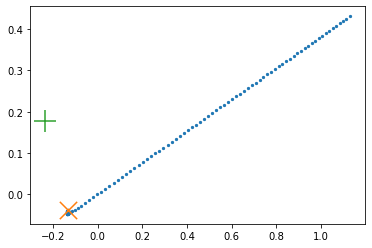

[12] loss: 0.716947


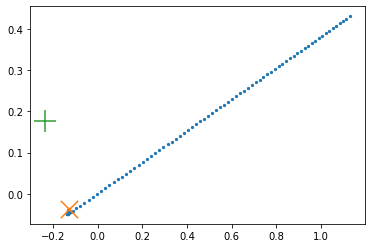

[13] loss: 0.716425


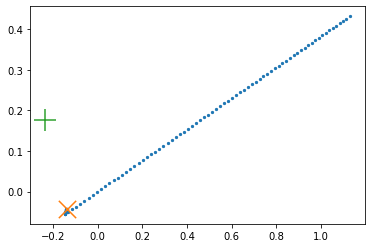

[14] loss: 0.716155


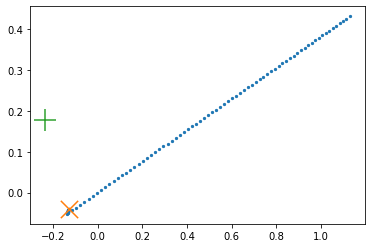

[15] loss: 0.716198


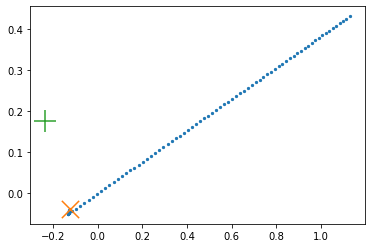

[16] loss: 0.715827


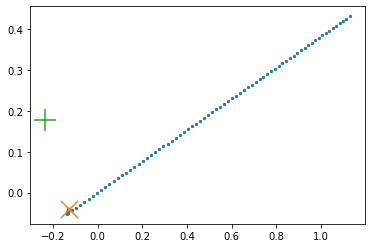

[17] loss: 0.715770


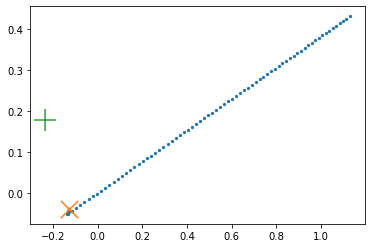

[18] loss: 0.715947


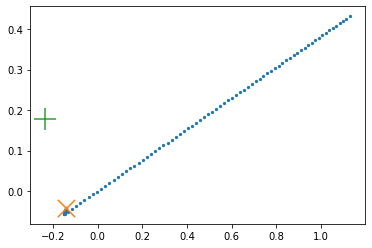

[19] loss: 2.522465


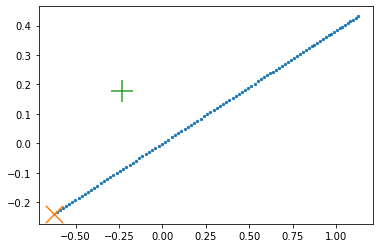

[20] loss: 2.522465


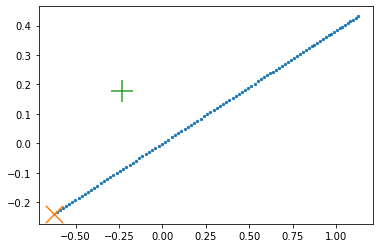

[21] loss: 2.522465


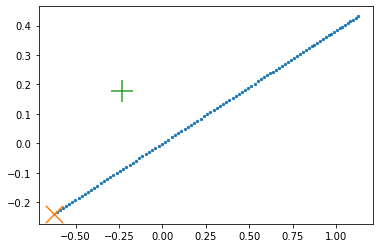

[22] loss: 2.522465


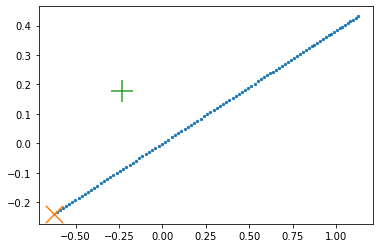

[23] loss: 2.522465


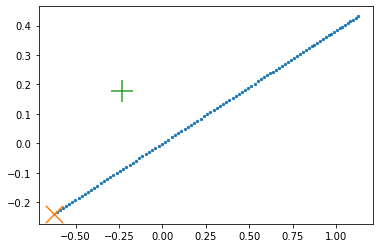

[24] loss: 2.522465


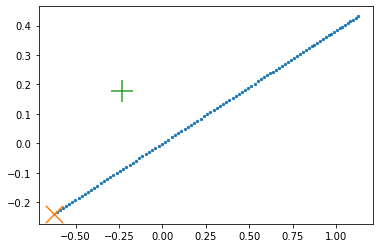

[25] loss: 2.522465


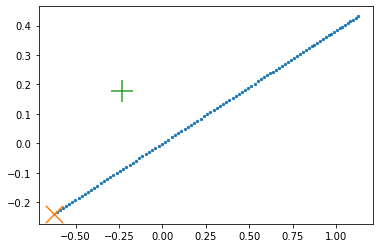

[26] loss: 2.522465


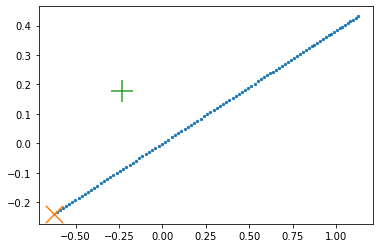

[27] loss: 2.522465


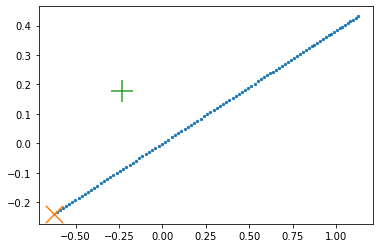

[28] loss: 2.522465


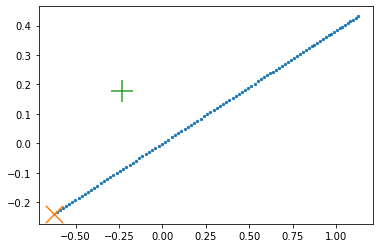

[29] loss: 2.522465


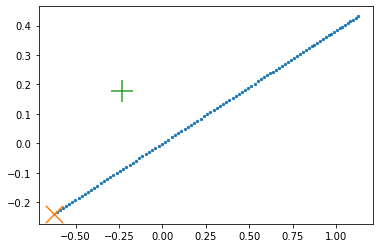

[30] loss: 2.522464


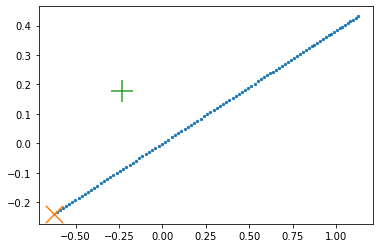

[31] loss: 2.522464


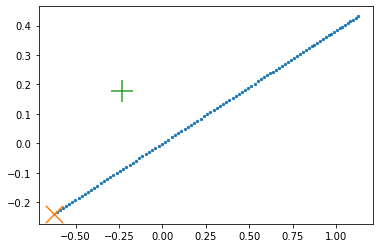

[32] loss: 2.522464


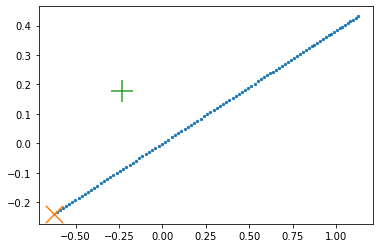

[33] loss: 2.522464


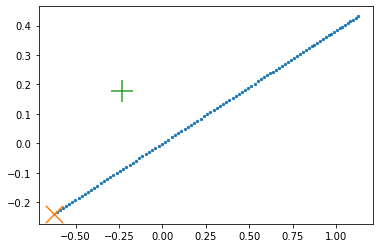

[34] loss: 1.642327


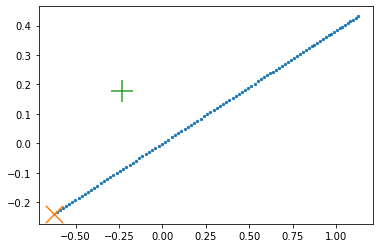

[35] loss: 1.642327


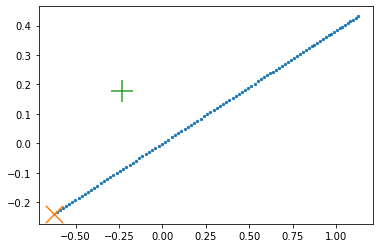

[36] loss: 1.642327


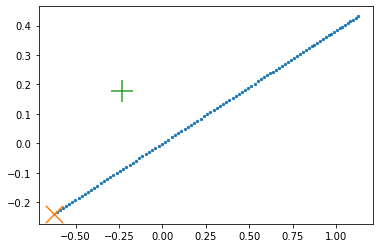

[37] loss: 1.642327


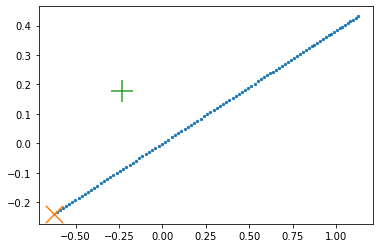

[38] loss: 1.642327


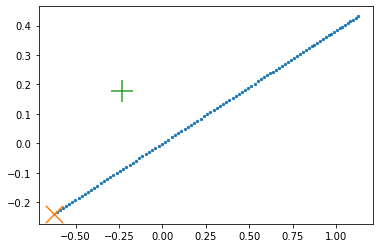

[39] loss: 1.642327


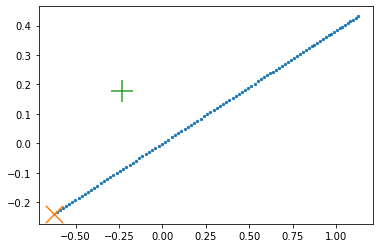

[40] loss: 1.642327


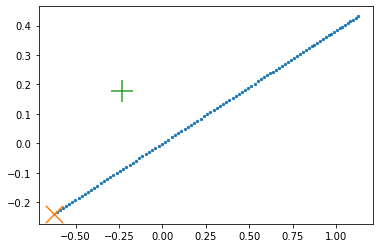

[41] loss: 1.642327


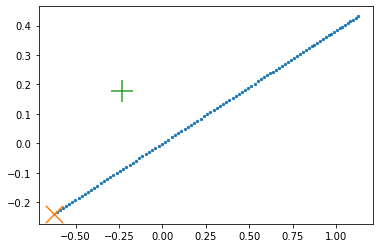

[42] loss: 1.642327


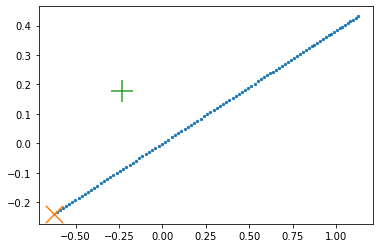

[43] loss: 1.642327


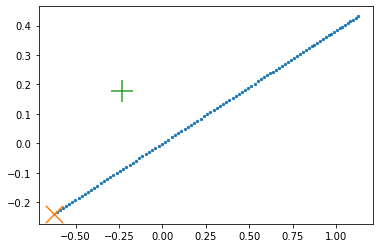

[44] loss: 1.642327


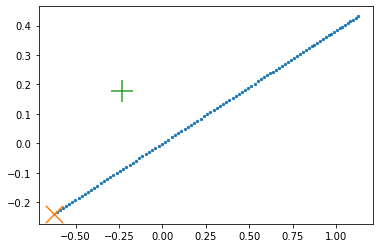

[45] loss: 1.642327


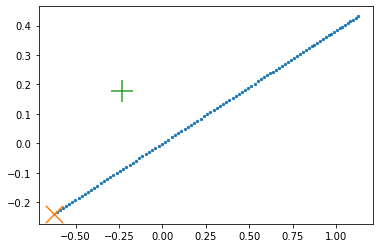

[46] loss: 1.642327


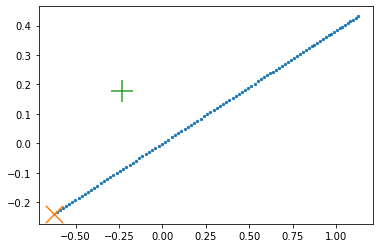

[47] loss: 1.642327


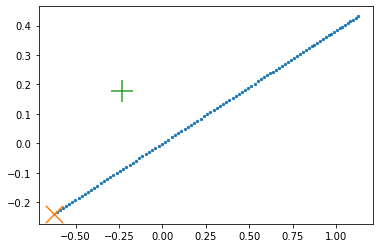

[48] loss: 1.642327


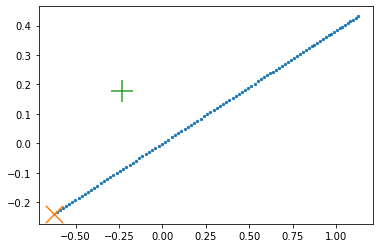

[49] loss: 1.642327


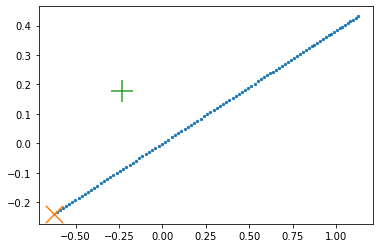

[50] loss: 1.642327


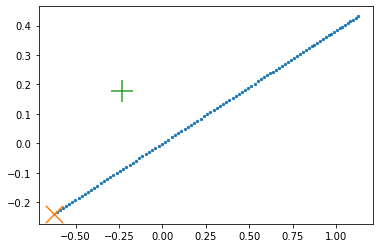

[51] loss: 1.642327


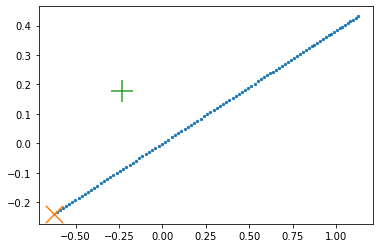

[52] loss: 1.642327


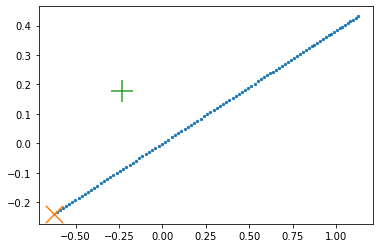

[53] loss: 1.642327


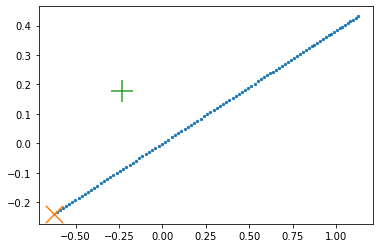

[54] loss: 1.642327


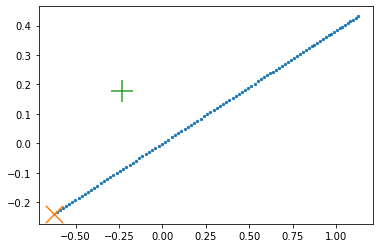

[55] loss: 1.642327


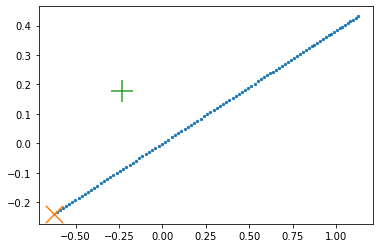

[56] loss: 1.642327


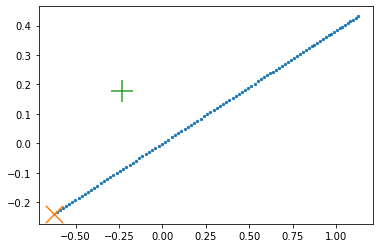

[57] loss: 1.642327


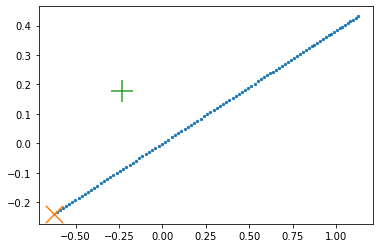

[58] loss: 1.642327


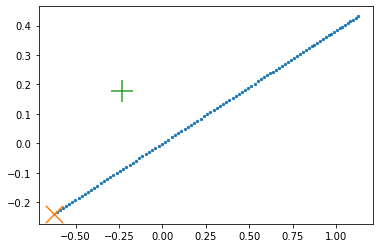

[59] loss: 1.642327


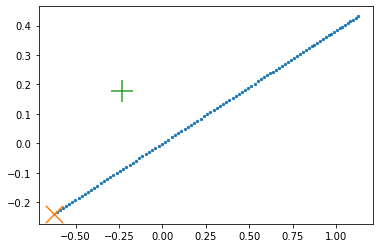

[60] loss: 1.642327


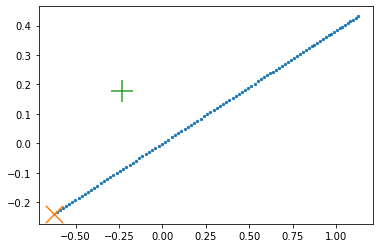

[61] loss: 1.642327


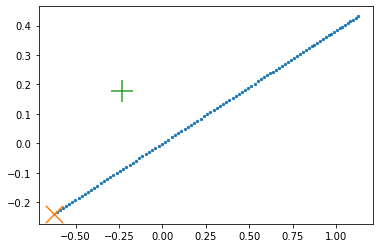

[62] loss: 1.642327


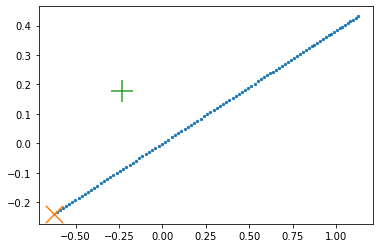

[63] loss: 1.642327


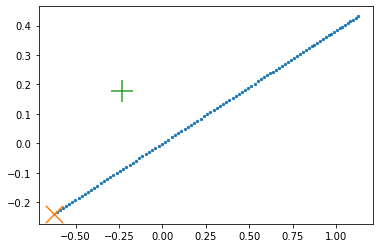

[64] loss: 1.642327


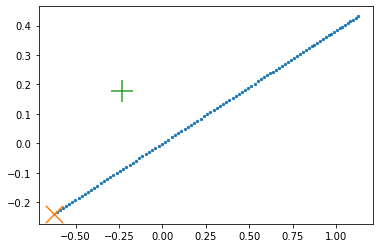

[65] loss: 1.642327


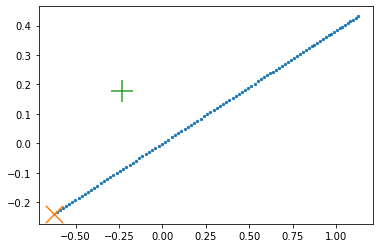

[66] loss: 1.642327


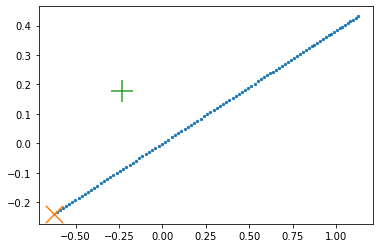

[67] loss: 1.642327


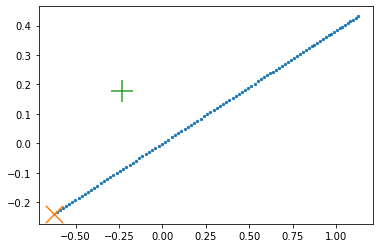

[68] loss: 1.642327


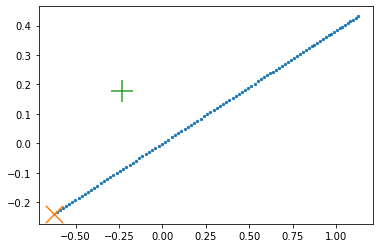

[69] loss: 1.642327


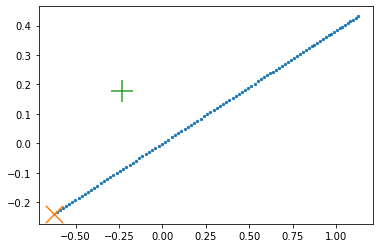

[70] loss: 1.642327


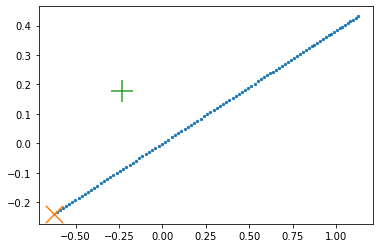

[71] loss: 1.642327


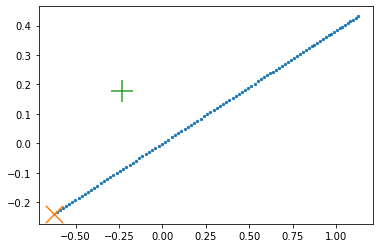

[72] loss: 1.642327


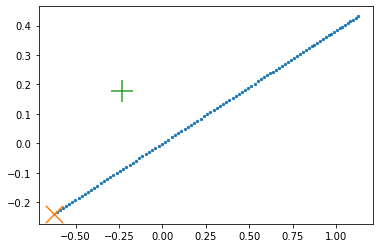

[73] loss: 1.642327


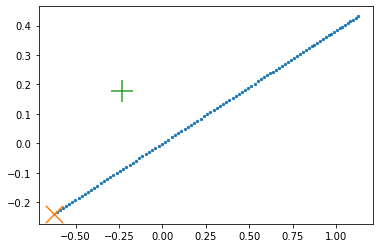

[74] loss: 1.642327


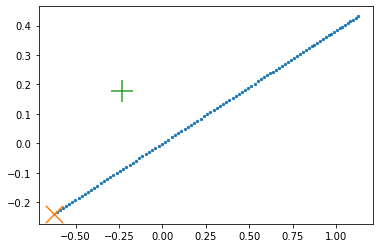

[75] loss: 1.642327


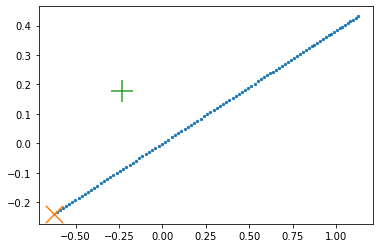

[76] loss: 1.642327


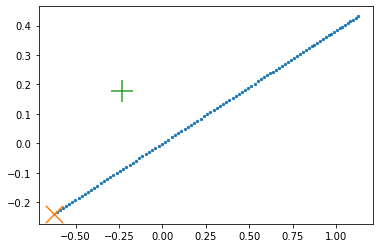

[77] loss: 1.642327


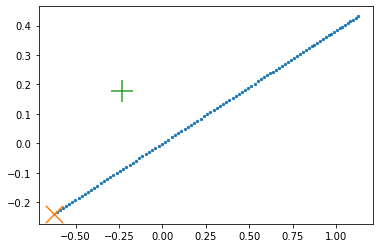

[78] loss: 1.642327


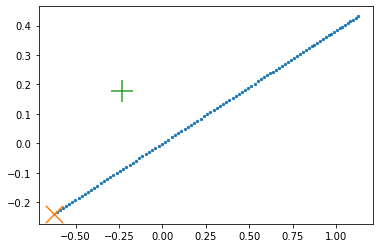

[79] loss: 1.642327


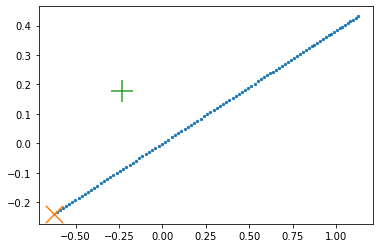

[80] loss: 1.642327


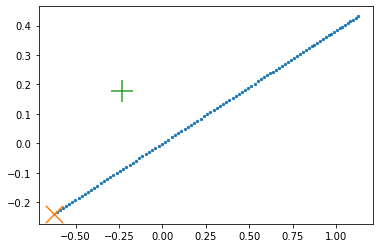

[81] loss: 1.642327


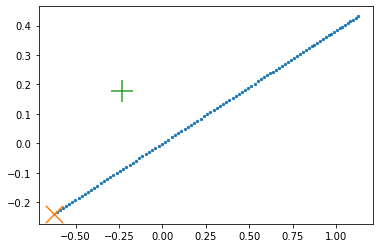

[82] loss: 1.642327


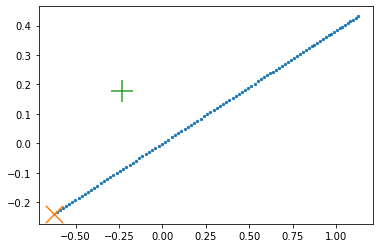

[83] loss: 1.642327


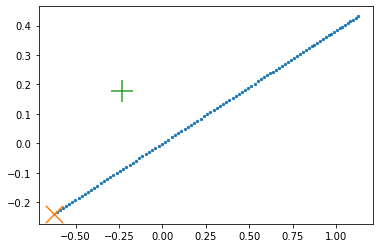

[84] loss: 1.642327


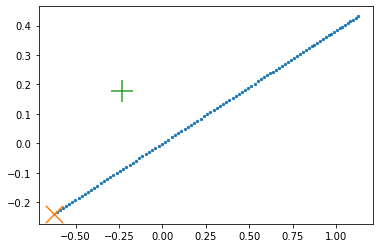

[85] loss: 1.642327


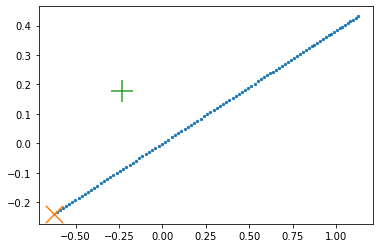

[86] loss: 1.642327


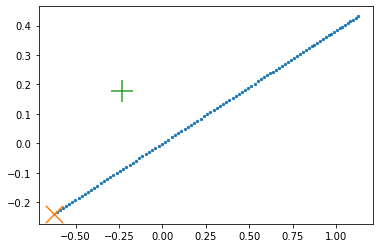

[87] loss: 1.642327


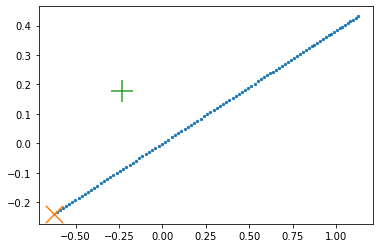

[88] loss: 1.642327


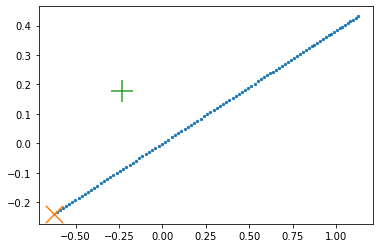

[89] loss: 1.642327


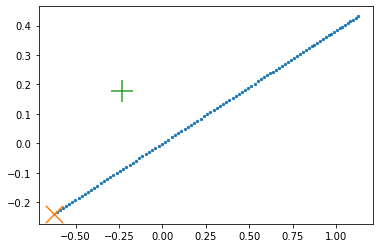

[90] loss: 1.642327


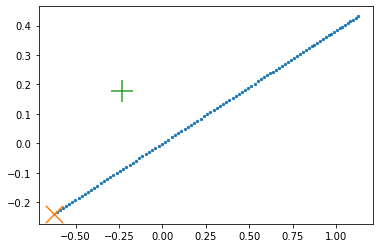

[91] loss: 1.642327


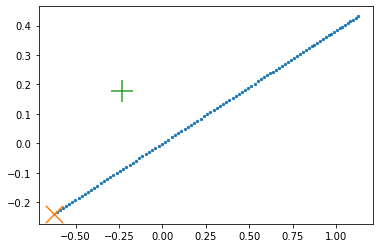

[92] loss: 1.642327


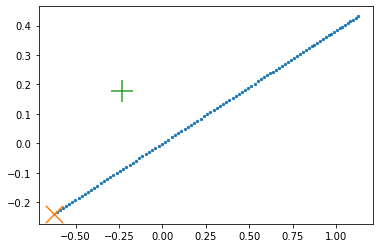

[93] loss: 1.642327


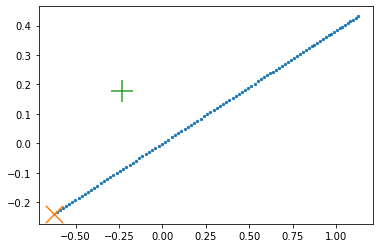

[94] loss: 1.642327


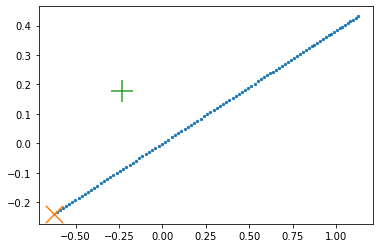

[95] loss: 1.642327


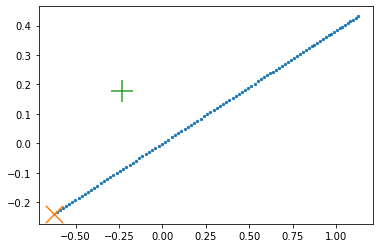

[96] loss: 1.642327


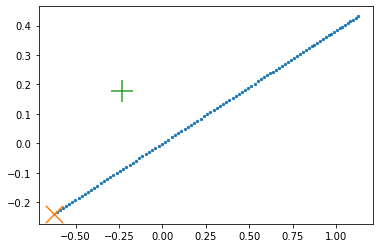

[97] loss: 1.642327


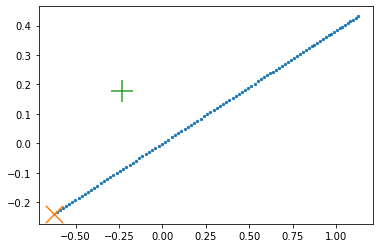

[98] loss: 1.642327


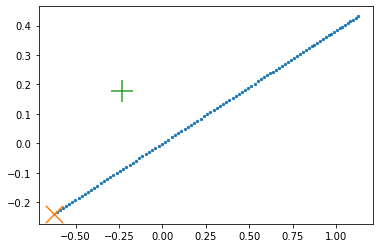

[99] loss: 1.642327


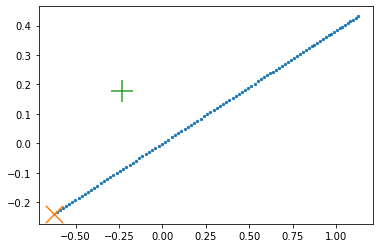

[100] loss: 1.642327


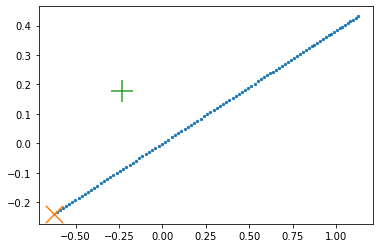

[101] loss: 1.642327


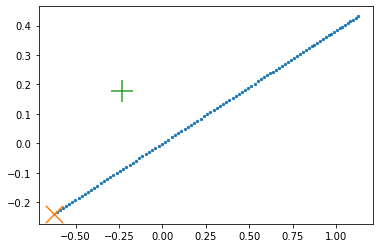

Landing Trajectory:


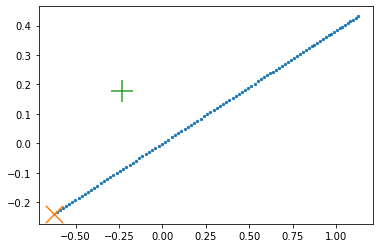

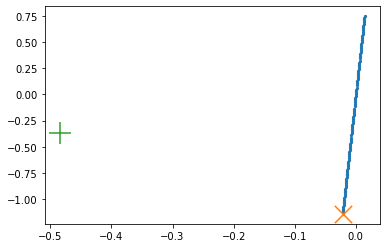

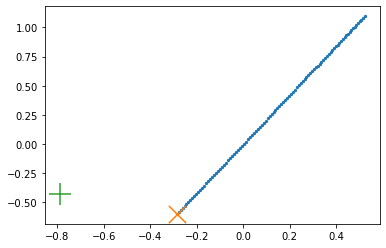

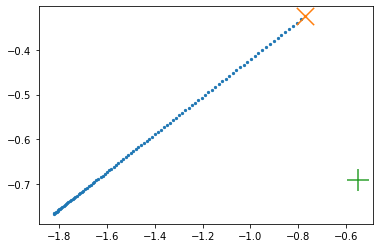

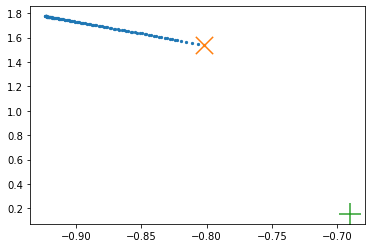

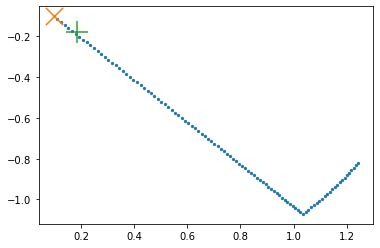

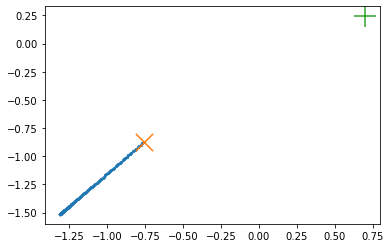

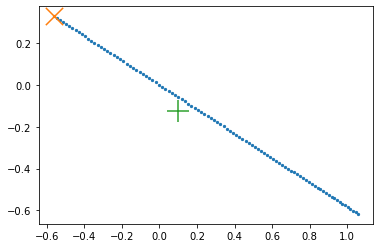

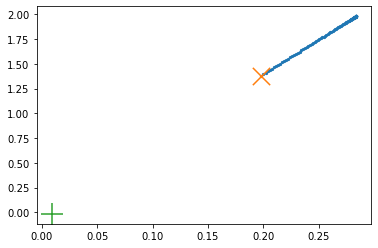

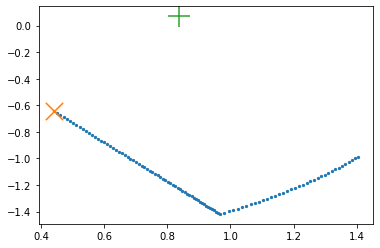

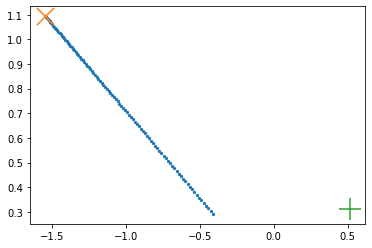

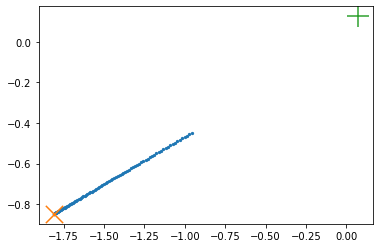

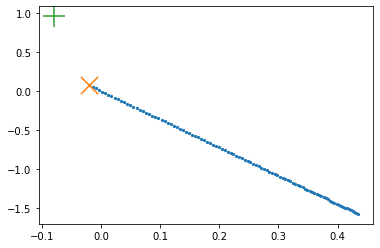

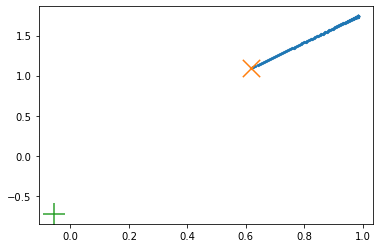

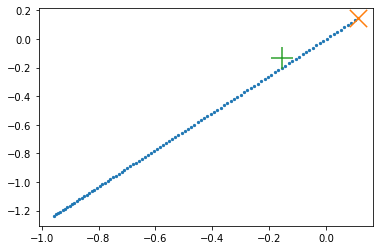

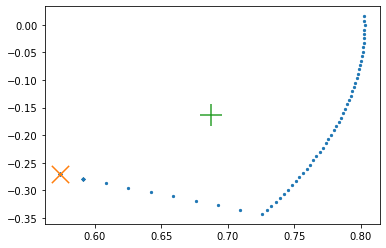

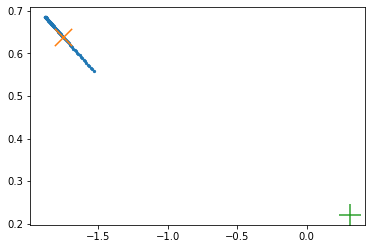

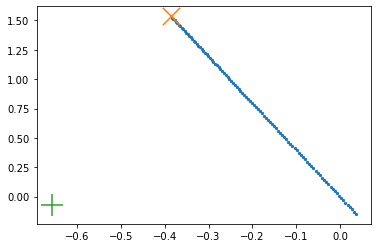

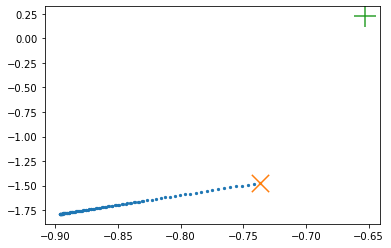

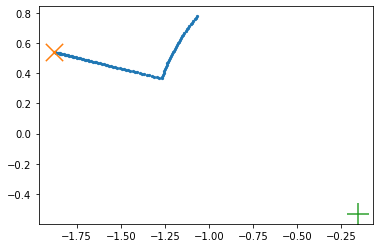

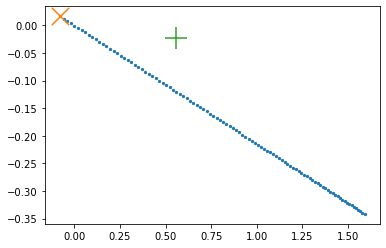

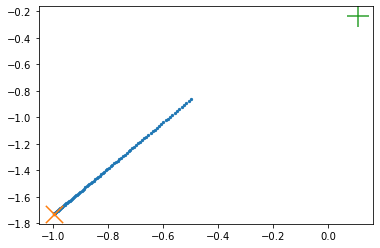

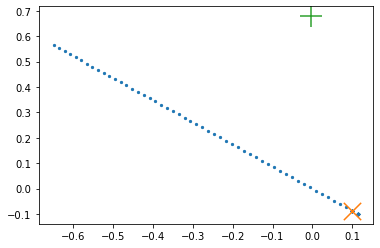

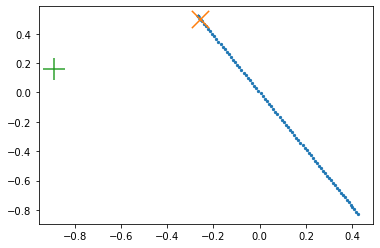

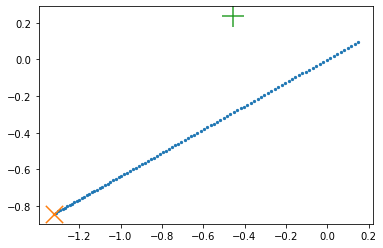

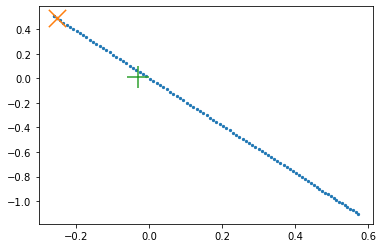

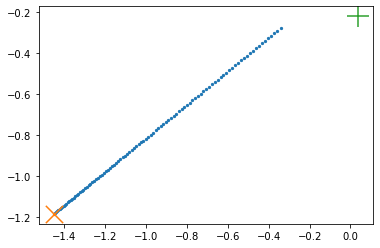

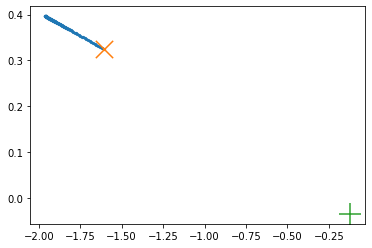

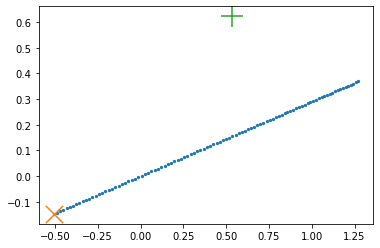

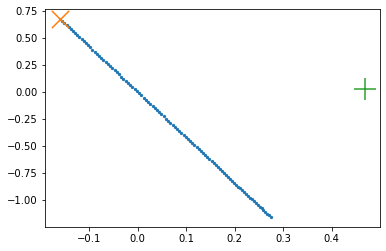

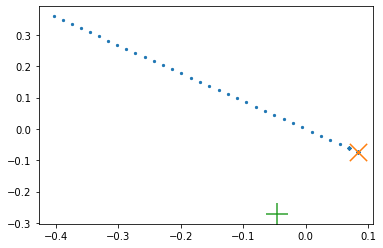

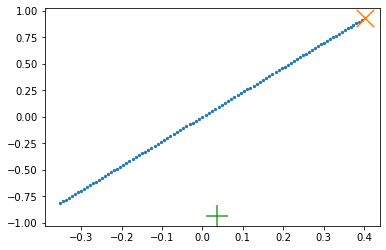

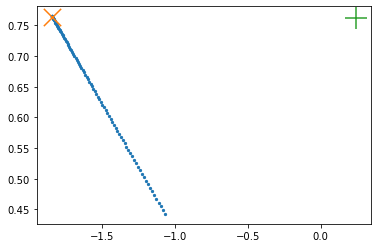

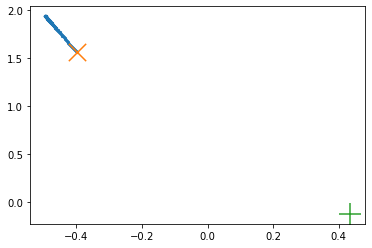

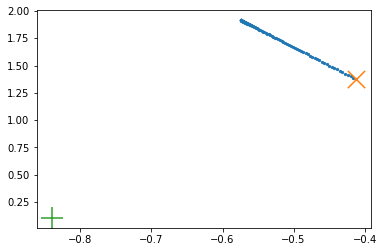

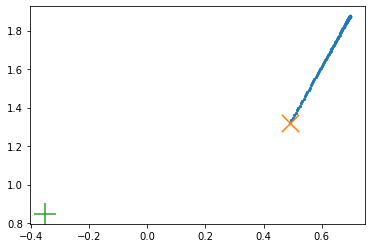

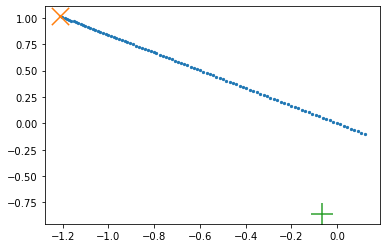

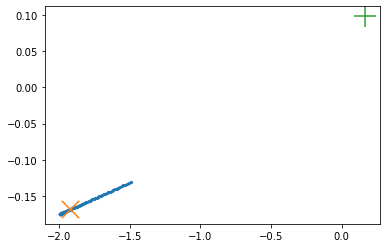

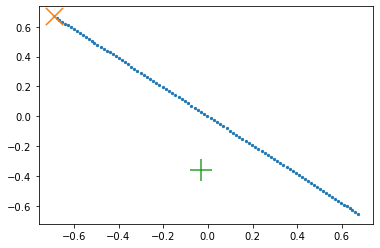

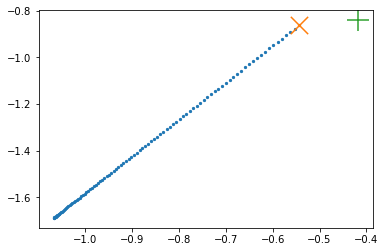

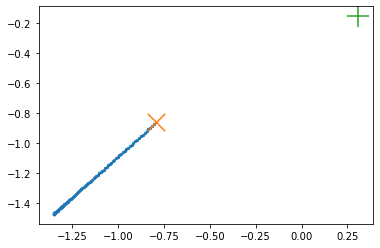

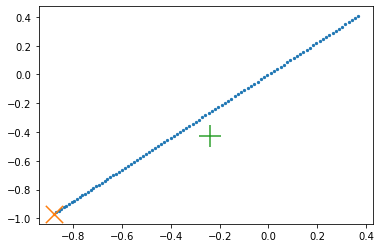

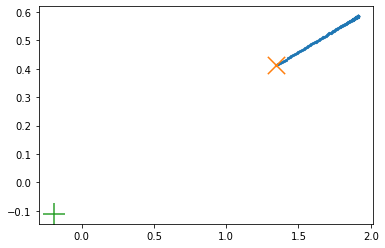

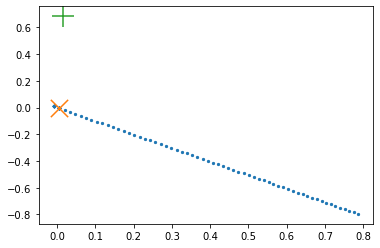

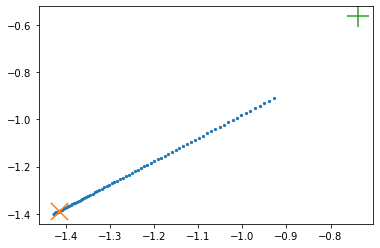

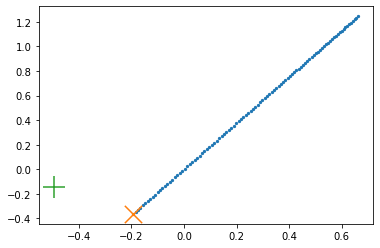

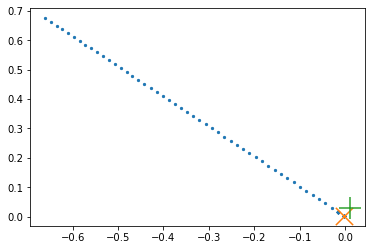

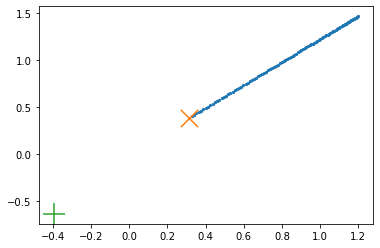

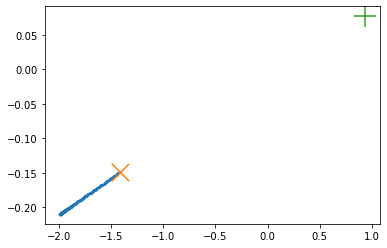

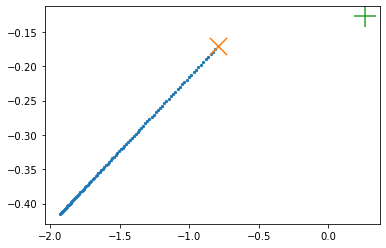

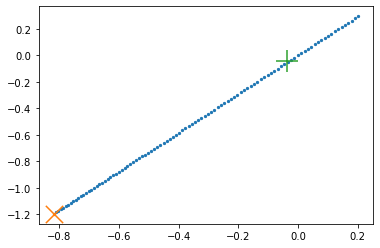

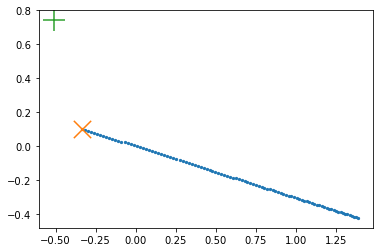

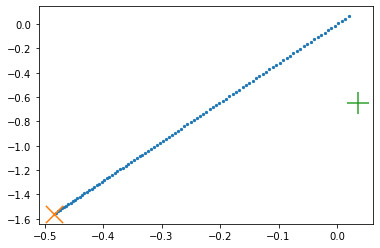

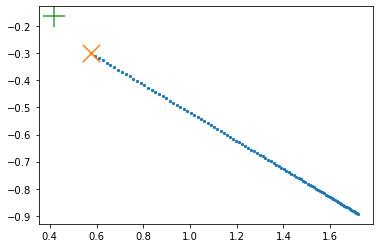

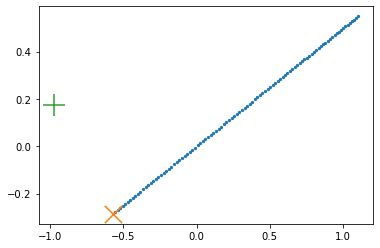

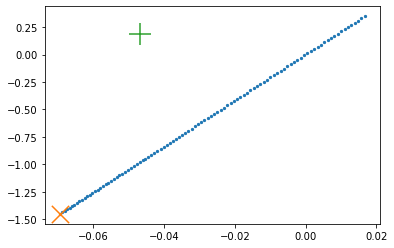

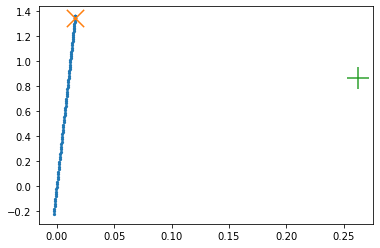

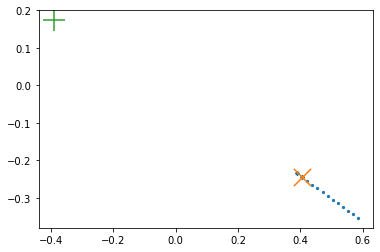

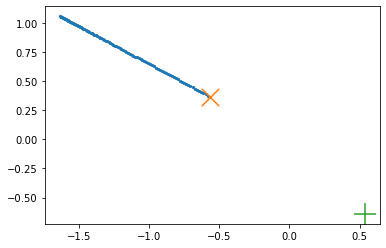

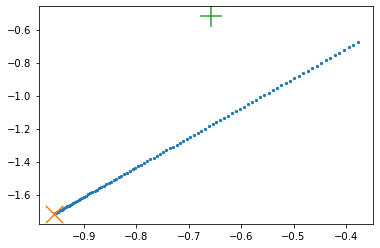

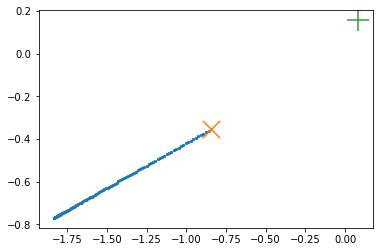

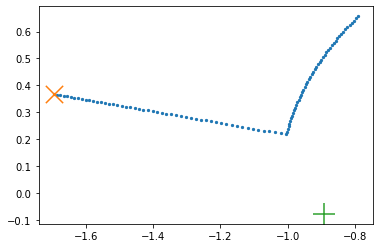

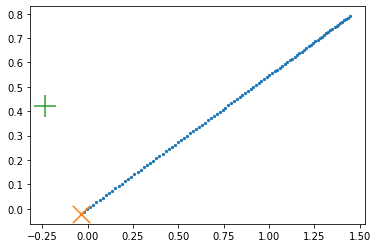

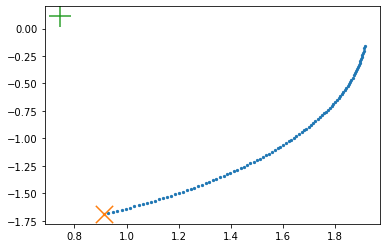

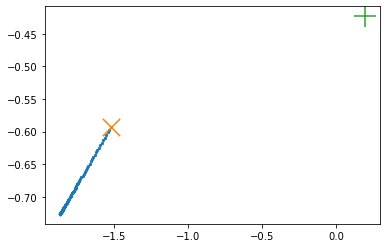

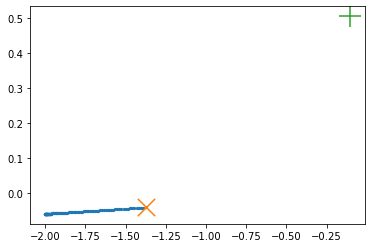

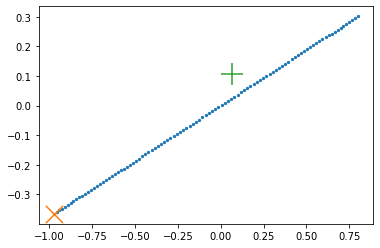

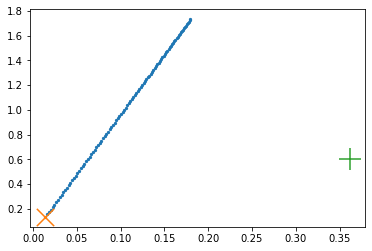

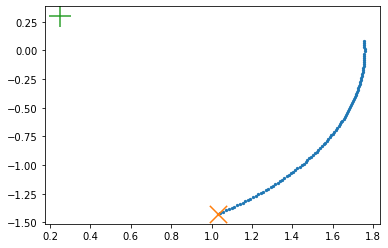

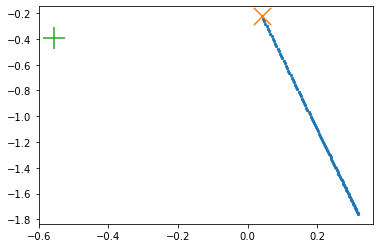

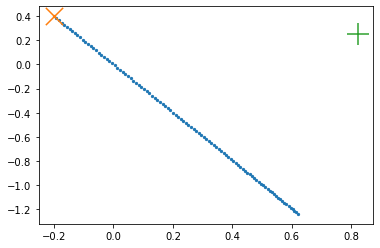

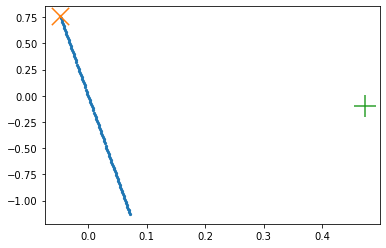

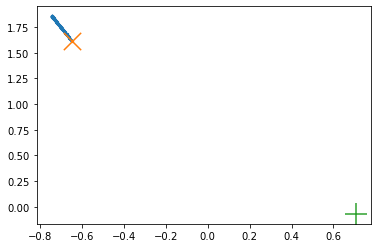

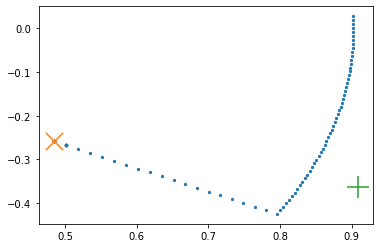

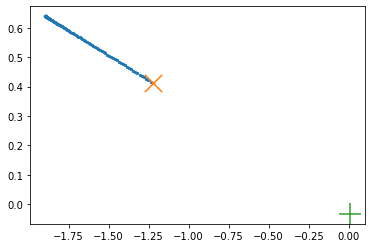

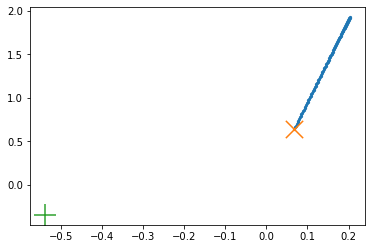

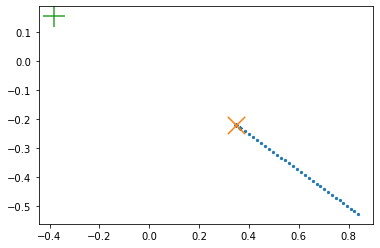

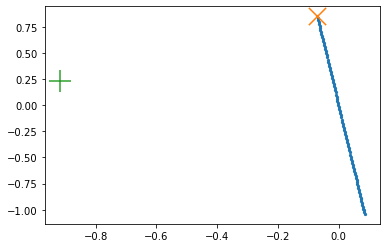

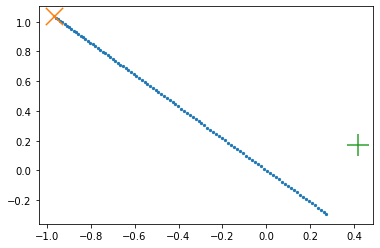

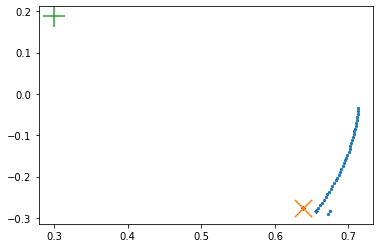

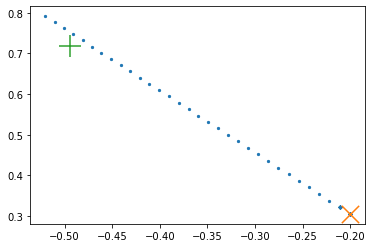

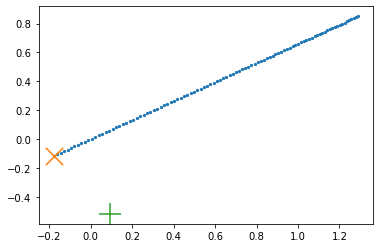

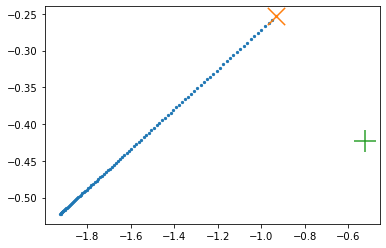

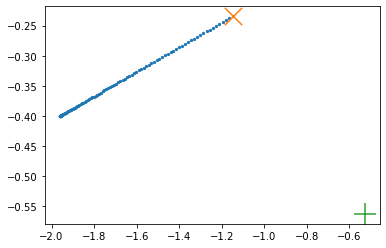

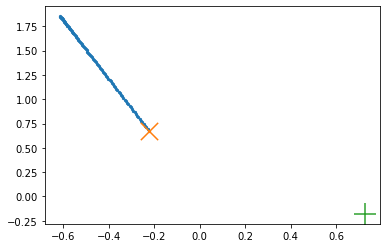

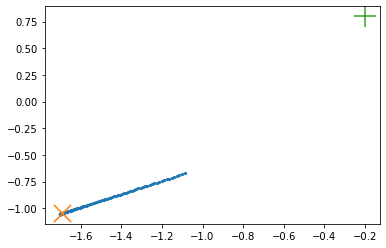

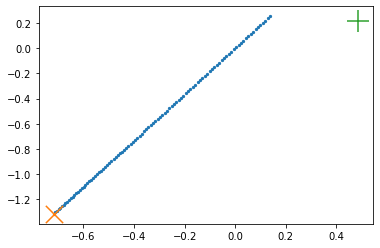

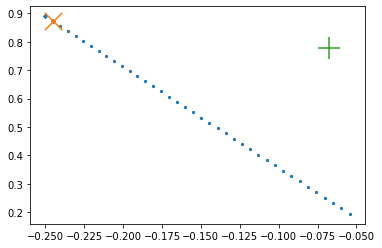

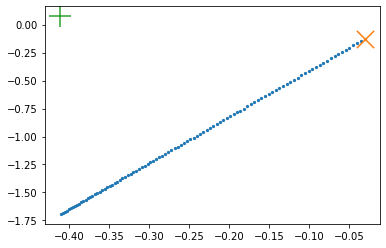

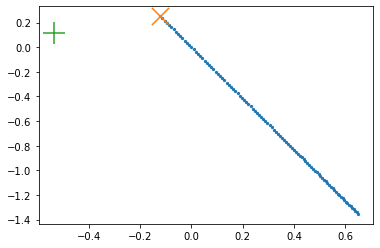

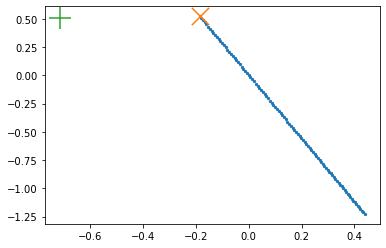

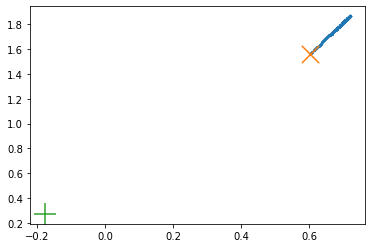

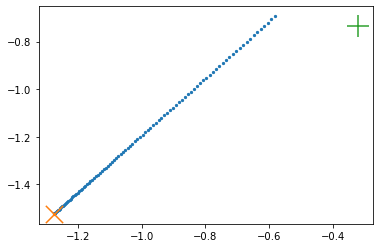

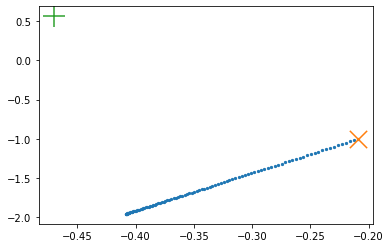

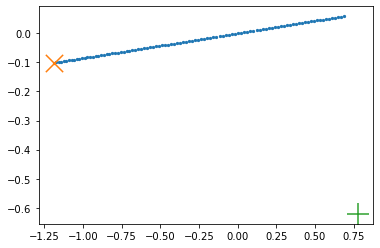

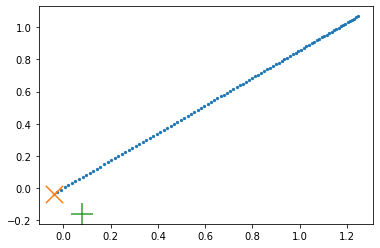

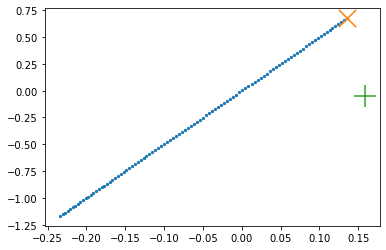

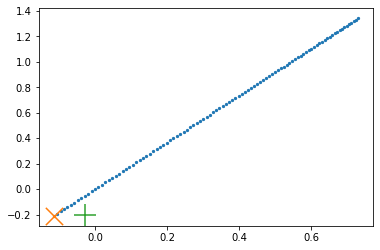

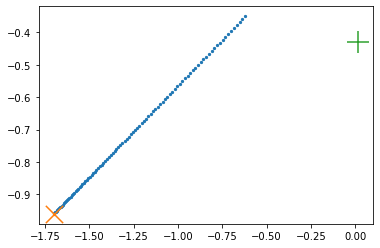

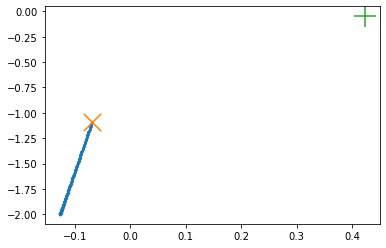

Convergence Plot:


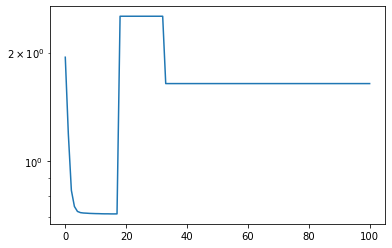

In [35]:
# Now it's time to run the code!

T = 100  # number of time steps
N = 100  # number of initial states
err = 0.001 # acceptable_error
itr = 100 # max_iteration
dim_input = 2  # state space dimensions
dim_hidden = 8  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation
o = Optimize(s)  # define optimizer
o.train(err,itr,N)  # solve the optimization problem

# path = './Landing_Model.pth' # save model
# t.save(c.state_dict(),path)

In [36]:
# Test the control model by some new samples:

# N_eval = 10 # number of initial states for testing
# d_eval = Dynamics()  # define dynamics
# model_eval =  Controller(dim_input, dim_hidden1, dim_hidden2, dim_output) # define controller
#
# path = './Landing_Model.pth' # load model
# model_eval.load_state_dict(t.load(path))
# model_eval.eval()
# print(N_eval)
# s_eval = Simulation(model_eval, d_eval, T, N_eval )
# eva = Evaluation(s_eval)  # initial evaluation simulator
# eva.test(N_eval) # Test